In [57]:
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


# Instantiate our lazy layer.
linear_layer = Linear(4)
# linear_layer
# # This will also call `build(input_shape)` and create the weights.
y = linear_layer(tf.ones((2, 2)))

y

2023-02-26 16:40:46.410357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 16:40:46.411696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-26 16:40:46.411774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-26 16:40:46.411789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.1559557 ,  0.13673338,  0.03280183, -0.11284401],
       [-0.1559557 ,  0.13673338,  0.03280183, -0.11284401]],
      dtype=float32)>

In [4]:

class Quadratic(keras.layers.Layer):
    """y = v.x^2 + w.x + b"""

    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.v = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(tf.math.square(inputs), self.v) + tf.matmul(inputs, self.w) + self.b


# Instantiate our lazy layer.
quadratic_layer = Quadratic(4)
# linear_layer
# # This will also call `build(input_shape)` and create the weights.
y = quadratic_layer(tf.ones((2, 2)))

y

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.071757  , -0.09422018, -0.0201699 , -0.02749731],
       [ 0.071757  , -0.09422018, -0.0201699 , -0.02749731]],
      dtype=float32)>

In [47]:


# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate our linear layer (defined above) with 10 units.
linear_layer = Linear(10)
# quadratic_layer = Quadratic(10)

# Instantiate a logistic loss function that expects integer targets.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):

    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        logits = linear_layer(x)

        # Loss value for this batch.
        loss = loss_fn(y, logits)

    # Get gradients of the loss wrt the weights.
    gradients = tape.gradient(loss, linear_layer.trainable_weights)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

    # Logging.
    if step % 100 == 0:
        print("Step:", step, "Loss:", float(loss))
        # print(gradients)


Step: 0 Loss: 2.3181254863739014
Step: 100 Loss: 2.300809383392334
Step: 200 Loss: 2.101893901824951
Step: 300 Loss: 2.1450233459472656
Step: 400 Loss: 1.9376022815704346
Step: 500 Loss: 1.9138786792755127
Step: 600 Loss: 1.8107740879058838
Step: 700 Loss: 1.695183515548706
Step: 800 Loss: 1.664708137512207
Step: 900 Loss: 1.6805589199066162


In [69]:
import pandas as pd
Start,End = 14,20
for i in range(Start,End):
    i1,i2=str(i),str(i+1)
    if i < 18:
        V2 = '_V2'
    else:
        V2 = ''
    root_url = f"Data/CA-DBB_HH_20{i1}01010000_20{i2}01010000{V2}.csv"
    df = pd.read_csv(root_url,parse_dates=['TIMESTAMP_START'],na_values=-9999)
    df = df.set_index('TIMESTAMP_START')
    if i == Start:
        Data = df.copy()
    else:
        Data = pd.concat(
            [Data,df]
        )


print(Data.columns)
Data = Data[['CO2', 'FC', 'FCH4', 'RH', 'TA', 'NETRAD', 'SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',
       ]].dropna()#.describe()
x_train = Data[['TA','RH','SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',]]


y_train = Data[['FC',]]

numeric_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = numeric_dataset.shuffle(y_train.shape[0]*2).batch(32)
dataset


Index(['TIMESTAMP_END', 'CO2', 'FC', 'G', 'H', 'LE', 'WD', 'WS', 'USTAR', 'PA',
       'RH', 'TA', 'NETRAD', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P',
       'T_SONIC', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD', 'FC_F', 'H_F',
       'LE_F', 'FCH4'],
      dtype='object')


<BatchDataset element_spec=(TensorSpec(shape=(None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [70]:

# Instantiate our linear layer (defined above) with 10 units.
linear_layer = Linear(10)

# Instantiate a MSE loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):

    # Open a GradientTape.
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        
        # Forward pass.
        pred = linear_layer(x)

        # Loss value for this batch.
        loss = loss_fn(y, pred)

    # Get gradients of the loss wrt the weights.
    gradients = tape.gradient(loss, linear_layer.trainable_weights)

    # Get gradients of the pred wrt x
    dy_dx = tape.gradient(pred,x)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

    # Logging.
    if step % 20 == 0:
        print("Step:", step, "Loss:", float(loss))
        # print(gradients)


Step: 0 Loss: 366.90777587890625
Step: 20 Loss: 176.35292053222656
Step: 40 Loss: 109.78567504882812
Step: 60 Loss: 86.64694213867188
Step: 80 Loss: 63.04811096191406
Step: 100 Loss: 44.86410903930664
Step: 120 Loss: 31.258987426757812
Step: 140 Loss: 20.99659538269043
Step: 160 Loss: 15.591156005859375
Step: 180 Loss: 13.000100135803223
Step: 200 Loss: 7.79887580871582
Step: 220 Loss: 7.274327278137207
Step: 240 Loss: 8.399686813354492
Step: 260 Loss: 4.178840160369873
Step: 280 Loss: 3.0784554481506348
Step: 300 Loss: 4.357378959655762
Step: 320 Loss: 4.146191596984863
Step: 340 Loss: 3.1943397521972656
Step: 360 Loss: 3.8595407009124756
Step: 380 Loss: 3.901423454284668
Step: 400 Loss: 5.0152435302734375
Step: 420 Loss: 3.932537794113159
Step: 440 Loss: 2.568971872329712
Step: 460 Loss: 5.402882099151611
Step: 480 Loss: 7.867133140563965
Step: 500 Loss: 4.454964637756348
Step: 520 Loss: 4.954476356506348


In [71]:
print(len(dy_dx))
print(y.shape)

28
(28, 1)


In [97]:
import pandas as pd
Start,End = 14,20
for i in range(Start,End):
    i1,i2=str(i),str(i+1)
    if i < 18:
        V2 = '_V2'
    else:
        V2 = ''
    root_url = f"Data/CA-DBB_HH_20{i1}01010000_20{i2}01010000{V2}.csv"
    df = pd.read_csv(root_url,parse_dates=['TIMESTAMP_START'],na_values=-9999)
    df = df.set_index('TIMESTAMP_START')
    if i == Start:
        Data = df.copy()
    else:
        Data = pd.concat(
            [Data,df]
        )


print(Data.columns)
Data = Data[['CO2', 'FC', 'FCH4', 'RH', 'TA', 'NETRAD', 'SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',
       ]].dropna()#.describe()
x_train = Data[['TA','RH','SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',]]


y_train = Data[['FC',]]

numeric_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = numeric_dataset.shuffle(y_train.shape[0]*2).batch(64)
# All = numeric_dataset.shuffle(y_train.shape[0]*2).batch(64)



Index(['TIMESTAMP_END', 'CO2', 'FC', 'G', 'H', 'LE', 'WD', 'WS', 'USTAR', 'PA',
       'RH', 'TA', 'NETRAD', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P',
       'T_SONIC', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD', 'FC_F', 'H_F',
       'LE_F', 'FCH4'],
      dtype='object')


In [98]:
def make_model(input_shape,hidden_nodes,name='Model'):
    # try:
    #     os.mkdir("temp_files/"+name)
    # except:
    #     clean_dir(name)
    input_layer = keras.layers.Input(input_shape)
    dense1 = keras.layers.Dense(
                                hidden_nodes,
                                activation='relu',
                                kernel_initializer="glorot_uniform",
                                bias_initializer="zeros"
                                )(input_layer)
    output_layer = keras.layers.Dense(1)(dense1)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer,name=name)
    print(model.summary())
    return(model)
    # model_json = model.to_json()
Model = make_model(9,35)
    # with open(f"temp_files/{name}/model_architecture.json", "w") as json_file:
    #     json_file.write(model_json)


Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_6 (Dense)             (None, 35)                350       
                                                                 
 dense_7 (Dense)             (None, 1)                 36        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
None


In [99]:

# Instantiate our linear layer (defined above) with 10 units.
# linear_layer = Linear(10)

# Instantiate a MSE loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):

    # Open a GradientTape.
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        
        # Forward pass.
        pred = Model(x)

        # Loss value for this batch.
        loss = loss_fn(y, pred)

    # Get gradients of the loss wrt the weights.
    gradients = tape.gradient(loss, Model.trainable_weights)

    # Get gradients of the pred wrt x
    dy_dx = tape.gradient(pred,x)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, Model.trainable_weights))

    # Logging.
    if step % 20 == 0:
        print("Step:", step, "Loss:", float(loss))
        # print(gradients)


Step: 0 Loss: 6836.369140625
Step: 20 Loss: 2610.975341796875
Step: 40 Loss: 360.251953125
Step: 60 Loss: 39.1677131652832
Step: 80 Loss: 23.27098846435547
Step: 100 Loss: 25.79976463317871
Step: 120 Loss: 12.03156852722168
Step: 140 Loss: 13.036674499511719
Step: 160 Loss: 10.370075225830078
Step: 180 Loss: 10.952024459838867
Step: 200 Loss: 4.816493988037109
Step: 220 Loss: 8.52723503112793
Step: 240 Loss: 6.819372177124023
Step: 260 Loss: 6.102263450622559


(9,)


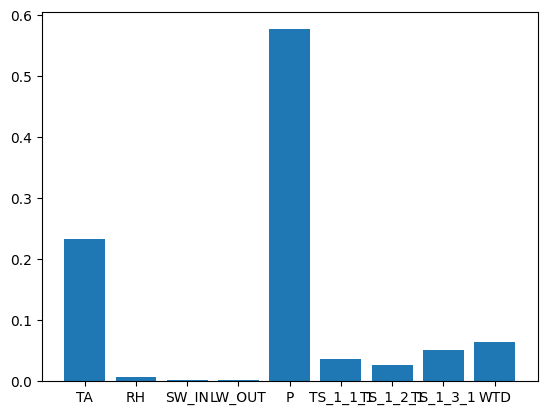

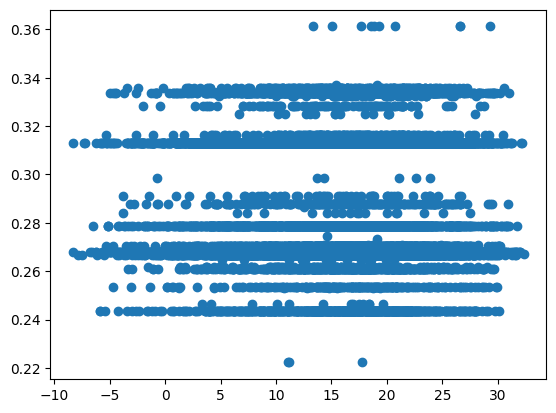

In [103]:

# x,y = numeric_dataset
# print(x)
# Full_dataset = numeric_dataset.shuffle(y_train.shape[0]).batch(y_train.shape[0])


# for step, (x, y) in enumerate(Full_dataset):
#     print(x.shape)
    
#     # Open a GradientTape.
#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch(x)
        
#         # Forward pass.
#         pred = Model(x)

#         # Loss value for this batch.
#         loss = loss_fn(y, pred)

#     # Get gradients of the loss wrt the weights.
#     gradients = tape.gradient(loss, Model.trainable_weights)

#     # Get gradients of the pred wrt x
#     dy_dx = tape.gradient(pred,x)


derivs = np.array([dy_dx[x].numpy() for x in range(len(dy_dx))])

SSD = (derivs**2).sum(axis=0)
print(SSD.shape)

plt.figure()
plt.bar(x_train.columns,SSD/SSD.sum(axis=0))

plt.figure()
plt.scatter(x_train['TA'],derivs[:,0])